
<div style="text-align: center;">
  <img src="https://github.com/Hack-io-Data/Imagenes/blob/main/01-LogosHackio/logo_amarillo@4x.png?raw=true" alt="esquema" />
</div>


# Laboratorio A/B Testing Parametrico


In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns

import matplotlib.pyplot as plt

from src import funciones as f

In [9]:
montaje=pd.read_csv("datos/linea_montaje.csv")
fluidos=pd.read_csv("datos/densidad_fluidos.csv")

#### Ejercicio 1:  Linea de montaje 

En una fabrica de componenetes textil se quiere comparar el tiempo de fabricacion de un determinado producto mediante tres métodos diferentes.  Se seleccionan aleatoriamente productos elaborados con cada uno de los métodos y se observa el tiempo de fabricación. 


1. ¿Se verifican los supuestos del modelo de análisis de la varianza?

2. ¿Existe evidencia de que el método influye en el tiempo medio de elaboración del producto?

3. La empresa valora que el tiempo de fabricación sea el menor posible. ¿Qué método cree que ofrece mejores resultados?

In [10]:
montaje.head(2)

,minutos,metodo
0,4.166484,A
1,4.887466,A


## EDA


No hay nulos ni duplicados en ninguno de los conjuntos de datos.   
  

***Linea de montaje:***  

- El método más usado es el método A con una frecuencia de 50 (Aunque realmente es porque ordena alfabeticamente porque si hay 3 métodos y 150 en total dan a 50 cada uno)  
  
- El tiempo medio de producción de un producto es de casi 5 minutos por producto. Al observar el mínimo observamos tiempo de producción unitario negativo lo que se debe a paradas de producción con lo que los tendrémos que mantener.  
  
***Densidad de fluidos:***   
  

- La temperatura media es 137,5 grados con una desviación de casi 28 grados.

- La densidad media es de 21,72 con una desviación muy leve  
  




In [14]:
montaje.describe(include="O").T

,count,unique,top,freq
metodo,150,3,A,50


In [12]:
montaje.describe().T

,count,mean,std,min,25%,50%,75%,max
minutos,150.0,4.895103,2.222707,-0.818899,3.528356,4.870153,6.328776,12.059491


In [13]:
montaje.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   minutos  150 non-null    float64
 1   metodo   150 non-null    object 
dtypes: float64(1), object(1)
memory usage: 2.5+ KB


In [19]:
montaje.duplicated().sum()

np.int64(0)

In [18]:
fluidos.head(2)

,temperatura,densidad
0,100,21.790655
1,100,21.725900


In [16]:
fluidos.describe().T

,count,mean,std,min,25%,50%,75%,max
temperatura,400.0,137.500000,27.985854,100.000000,118.75000,137.500000,156.250000,175.000000
densidad,400.0,21.733028,0.169214,21.323342,21.61463,21.742521,21.843457,22.170432


In [17]:
fluidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperatura  400 non-null    int64  
 1   densidad     400 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 6.4 KB


In [20]:
fluidos.duplicated().sum()

np.int64(0)

In [ ]:
class Asunciones:
    def __init__(self, dataframe, columna_numerica):

        self.dataframe = dataframe
        self.columna_numerica = columna_numerica
        
    

    def identificar_normalidad_analitica(self, metodo='shapiro', alpha=0.05, verbose=True):
        """
        Evalúa la normalidad de una columna de datos de un DataFrame utilizando la prueba de Shapiro-Wilk o Kolmogorov-Smirnov.

        Params:
            metodo (str): El método a utilizar para la prueba de normalidad ('shapiro' o 'kolmogorov').
            alpha (float): Nivel de significancia para la prueba.
            verbose (bool): Si se establece en True, imprime el resultado de la prueba. Si es False, Returns el resultado.

        Returns:
            bool: True si los datos siguen una distribución normal, False de lo contrario.
        """

        if metodo == 'shapiro':
            _, p_value = stats.shapiro(self.dataframe[self.columna_numerica])
            resultado = p_value > alpha
            if resultado == True:
                mensaje = f"los datos siguen una distribución normal según el test de Shapiro-Wilk."
            else:
                mensaje = f"los datos no siguen una distribución normal según el test de Shapiro-Wilk."
        
        elif metodo == 'kolmogorov':
            normalizale = self.dataframe[self.columna_numerica]
            loc, scale = stats.norm.fit(normalizale) # Normalizamos para que devuelva un pvalue como dios manda
            
            _, p_value = stats.kstest(normalizale, 'norm',args=(loc,scale))
            resultado = p_value > alpha
            if resultado:
                mensaje = f"los datos siguen una distribución normal según el test de Kolmogorov-Smirnov."  
            else:
                 mensaje = f"los datos no siguen una distribución normal según el test de Kolmogorov-Smirnov."
        else:
            raise ValueError("Método no válido. Por favor, elige 'shapiro' o 'kolmogorov'.")

        if verbose:
            print(f"Para la columna {self.columna_numerica}, {mensaje}")
        else:
            return resultado

        
    def identificar_homogeneidad (self,  columna_categorica):
        
        """
        Evalúa la homogeneidad de las varianzas entre grupos para una métrica específica en un DataFrame dado.

        Params:
        - columna (str): El nombre de la columna que se utilizará para dividir los datos en grupos.
        - columna_categorica (str): El nombre de la columna que se utilizará para evaluar la homogeneidad de las varianzas.

        Returns:
        No Returns nada directamente, pero imprime en la consola si las varianzas son homogéneas o no entre los grupos.
        Se utiliza la prueba de Levene para evaluar la homogeneidad de las varianzas. Si el valor p resultante es mayor que 0.05,
        se concluye que las varianzas son homogéneas; de lo contrario, se concluye que las varianzas no son homogéneas.
        """
        
        # lo primero que tenemos que hacer es crear tantos conjuntos de datos para cada una de las categorías que tenemos, Control Campaign y Test Campaign
        valores_evaluar = []
        
        for valor in self.dataframe[columna_categorica].unique():
            valores_evaluar.append(self.dataframe[self.dataframe[columna_categorica]== valor][self.columna_numerica])

        statistic, p_value = stats.levene(*valores_evaluar)
        if p_value > 0.05:
            print(f"En la variable {columna_categorica} las varianzas son homogéneas entre grupos.")
        else:
            print(f"En la variable {columna_categorica} las varianzas NO son homogéneas entre grupos.")


1. ¿Se verifican los supuestos del modelo de análisis de la varianza?


In [47]:
#antes de analizar los supuestos de la homocedasticidad, hay que comprobar la normalidad para saber que método usar para comprobar la homocedasticidad
#Uso shapiro aunque sé que debería usar la otra por el tamaño de la muestra

print(stats.shapiro(montaje["minutos"]))
print(stats.shapiro(montaje[montaje["metodo"] == "C"]["minutos"]))  #filtro por el grupo y me quedo solo con la métrica
print(stats.shapiro(montaje[montaje["metodo"] == "B"]["minutos"]))  #filtro por el grupo y me quedo solo con la métrica
print(stats.shapiro(montaje[montaje["metodo"] == "A"]["minutos"]))  #filtro por el grupo y me quedo solo con la métrica


ShapiroResult(statistic=np.float64(0.9912069518918302), pvalue=np.float64(0.4793383678320556))
ShapiroResult(statistic=np.float64(0.9681970572461548), pvalue=np.float64(0.19529544753589662))
ShapiroResult(statistic=np.float64(0.9493992809043919), pvalue=np.float64(0.032232156523145025))
ShapiroResult(statistic=np.float64(0.9827436667928682), pvalue=np.float64(0.6719488345577499))


In [60]:
normalizale = montaje["minutos"]
loc, scale = stats.norm.fit(normalizale) # Normalizamos para que devuelva un p-value 
_, p_value = stats.kstest(normalizale, 'norm',args=(loc,scale))
resultado = p_value > 0.05
print(f"los minutos siguen una distribución normal según el test de Kolmogorov-Smirnov.{resultado}")

los minutos siguen una distribución normal según el test de Kolmogorov-Smirnov.True


<Axes: xlabel='minutos', ylabel='Count'>

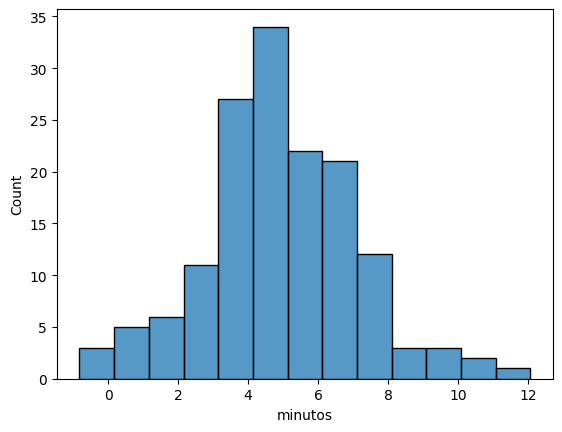

In [ ]:
sns.histplot(x="minutos", data= montaje)

*Analizado de forma conjunta:*  
  

Dado que el p-value > 0,05 , no hay evidencia suficiente para rechazar la hipótesis nula. Esto quiere decir (dado que nuestra hipótesis nula es que la distribución sea normal) que la distribución de los minutos es normal. Ahora que lo sabemos, procededmos a comprobar la homocedasticidad con el test de barlett.


*Individual:*  

C y A:  
  
Dado que el p-value > 0,05 , no hay evidencia suficiente para rechazar la hipótesis nula. Esto quiere decir (dado que nuestra hipótesis nula es que la distribución sea normal) que la distribución de los minutos es normal para los métodos C y A. Ahora que lo sabemos, procededmos a comprobar la homocedasticidad con el test de bartlett.


In [61]:
def comprobar_homocedasticidad(df, columna_grupos, columnas_metrica):
    unicos=df[columna_grupos].unique()   #lista de grupos
    for grupo in unicos:
        df_metrica= df[df[columna_grupos]== grupo][columnas_metrica]
        globals()[grupo] = df_metrica                                   #globals permite poner un parametro de una funcion en la variable a definir (de normal no se puede)
                                                                        #basicamente el globals lo empaqueta en un especie de diccionario en la que lo unico que se almacena en unicos (lista_grupo) son los nombres A B y C


    print(stats.bartlett(*[globals()[var] for var in unicos]))                  #al desempaquetar, de la A obtenemos sus estadisticos el * es para quitar la lista

comprobar_homocedasticidad(montaje, "metodo", "minutos")

BartlettResult(statistic=np.float64(0.7587362059281331), pvalue=np.float64(0.6842936757694211))


<Axes: xlabel='minutos', ylabel='Count'>

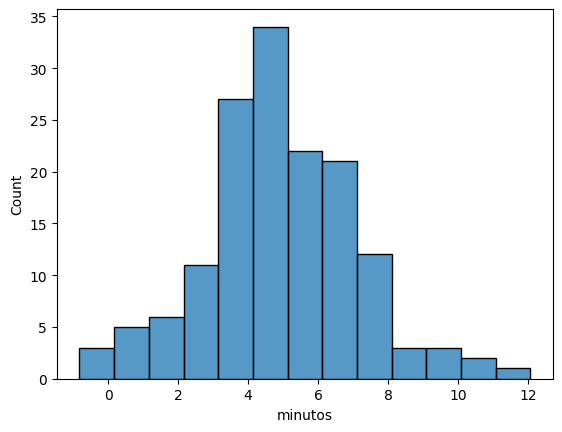

In [ ]:
sns.histplot(x="minutos", data= montaje)

In [62]:
stats.bartlett(montaje[montaje["metodo"]== "C"]["minutos"], montaje[montaje["metodo"]== "A"]["minutos"], montaje[montaje["metodo"]== "B"]["minutos"])

BartlettResult(statistic=np.float64(0.7587362059281331), pvalue=np.float64(0.6842936757694211))

Dado que el p-value > 0,05 , no hay evidencia suficiente para rechazar la hipótesis nula. Esto quiere decir que la distribución de los minutos es homocedástica.


2. ¿Existe evidencia de que el método influye en el tiempo medio de elaboración del producto?


In [ ]:
#Aqui supongo que tengo que hacer un anova ya que tengo que hacer un contraste de hipotesis de 3 

def calcular_anova(df, columna_grupos, columnas_metrica):
    unicos=df[columna_grupos].unique()   #lista de grupos
    for grupo in unicos:
        df_metrica= df[df[columna_grupos]== grupo][columnas_metrica]
        globals()[grupo] = df_metrica                                  

    print(stats.f_oneway(*[globals()[var] for var in unicos]))                 

calcular_anova(montaje, "metodo", "minutos")


F_onewayResult(statistic=np.float64(4.275128289148849), pvalue=np.float64(0.015679251126397998))


Dado que el p-value es < 0,05 , no hay evidencia suficiente para aceptar la hipótesis nula (Nuestra hipótesis nula es que la diferencia en el tiempo medio de los tres métodods era = 0). Por ello podemos decir que si que existen diferencias en los tiempos de producción medios en los productos dependiendo del método de producción.


3. La empresa valora que el tiempo de fabricación sea el menor posible. ¿Qué método cree que ofrece mejores resultados?

In [30]:
#ahora vamos a utilizar una t- student porque vamos a comprara métodos de 2 en 2.
print(stats.ttest_ind(montaje[montaje["metodo"]== "C"]["minutos"], montaje[montaje["metodo"]== "A"]["minutos"]))       
print(stats.ttest_ind(montaje[montaje["metodo"]== "C"]["minutos"], montaje[montaje["metodo"]== "B"]["minutos"])) 
print(stats.ttest_ind(montaje[montaje["metodo"]== "B"]["minutos"], montaje[montaje["metodo"]== "A"]["minutos"]))

TtestResult(statistic=np.float64(1.9822369728858387), pvalue=np.float64(0.05025304295700147), df=np.float64(98.0))
TtestResult(statistic=np.float64(2.7945789450116494), pvalue=np.float64(0.006252328381189883), df=np.float64(98.0))
TtestResult(statistic=np.float64(-0.8500751462606051), pvalue=np.float64(0.3973553695139316), df=np.float64(98.0))


Tanto en la hipotesis nula del primer contraste (C y A) como en el segundo (C y B) el p-value es < a 0,05 lo que significa que no hay evidencia suficiente para aceptar la Ho, es decir, que si que hay diferencias en los tiempos de prodcucción unitarios entre esos métodos. Mientras que en el caso restante(B y A) no hay evidencia suficiente para poder rechazar la Ho lo que significa que no podemos afirmar que haya diferencias en los tiempos medios de producción entre esos dos métodos. Gracias al gráfico, sacamos que el C es diferente pero no porque tarde menos sino porque tarda más lo que nos deja solo con la opción A o la opción B pero una vez más dado que el método B tiene valores negativos debido a paradas de producción, nos quedaríamos con que el método A sería el más optimo en cuanto al tiempo unitario medio de producción.

<Axes: xlabel='metodo', ylabel='minutos'>

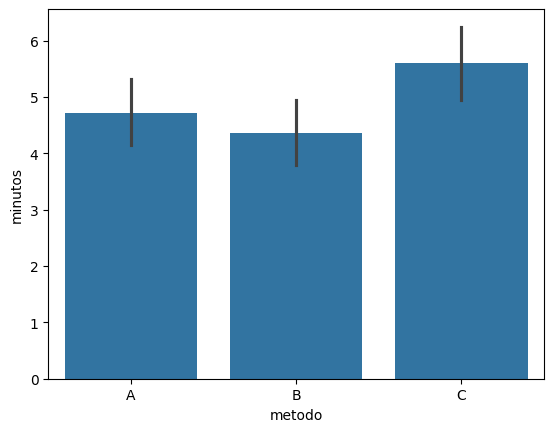

In [ ]:
sns.barplot(x="metodo", y= "minutos", data= montaje)

#### Ejercicio 2: Densidad de Fluidos 


La convección es un mecanismo fundamental de transferencia de calor en fluidos, que ocurre debido a las variaciones en la densidad provocadas por diferencias de temperatura. Este fenómeno se manifiesta cuando las porciones del fluido que se calientan, al volverse menos densas, ascienden hacia regiones de menor temperatura, mientras que las porciones más frías, al ser más densas, descienden hacia las zonas donde la temperatura es más alta. Este movimiento continuo da lugar a las llamadas corrientes de convección, las cuales desempeñan un papel crucial en la distribución homogénea de la temperatura dentro del fluido, promoviendo un equilibrio térmico.

En este contexto, se ha diseñado y ejecutado un experimento con el propósito de investigar cómo se ve afectada la densidad de un fluido cuando se incrementa la temperatura en una región específica del sistema; por tanto se asegura la independencia y aleatoriedad del mismo. El objetivo del experimento es comprender en detalle las modificaciones en la densidad que resultan de este aumento térmico y cómo estas afectan el comportamiento global del fluido.


1. Analiza las suposiciones del modelo: ¿Se cumplen las condiciones de homocedasticidad, independencia y normalidad?
2. ¿Tiene la temperatura un impacto notable en la densidad del fluido?
3. ¿Es posible concluir que las temperaturas de 100 y 125 provocan, en promedio, una menor densidad en el fluido comparadas con las temperaturas de 150 y 175?

In [2]:
# Tu codigo aqui